In [ ]:
# !pip install optuna
# !pip install catboost
# !pip install lightgbm
# !pip install xgboost

# Проект: классификация

## Задача

Построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать, воспользуется он предложением об открытии депозита или нет.

In [243]:
# Импорт библиотек для обработки данных
import pandas as pd
import numpy as np
import re

# Импорт библиотек для выполнения статистических тестов
from scipy import stats
from scipy.stats import shapiro, probplot, chi2_contingency
from scipy.stats import f_oneway, kruskal

# Импорт библиотек для визуализации
import matplotlib.pyplot as plt
import seaborn as sns

# Импорт библиотек для обработки и подготовки данных
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer

# Импорт библиотек для работы с моделями
from sklearn import linear_model, tree, ensemble, metrics
from sklearn.ensemble import (IsolationForest, BaggingClassifier,
                              RandomForestClassifier, GradientBoostingClassifier,
                              StackingClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif

# Импорт библиотек для градиентных методов
import lightgbm as lgb
import xgboost as xgb

# Импорт библиотеки для оптимизации гиперпараметров
import optuna

# Импорт библиотеки CatBoost
import catboost as cb

# Установка параметров визуализации
sns.set_theme('notebook')
sns.set_palette('RdGy')

# Игнорирование предупреждений
import warnings
warnings.filterwarnings('ignore')

In [2]:
%%capture
!wget https://lms-cdn.skillfactory.ru/assets/courseware/v1/dab91dc74eb3cb684755123d224d262b/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/bank_fin.zip
!unzip bank_fin.zip

In [240]:
df = pd.read_csv('bank_fin.csv', sep = ';')


# **Предобработка данных**
## Знакомство с данными, обработка пропусков и выбросов

Признаки, имеющиеся в данных:

**Данные о клиентах банка включают следующие признаки:**

* age (возраст)
* job (сфера занятости)
* marital (семейное положение)
* education (уровень образования)
* default (имеется ли просроченный кредит)
* housing (имеется ли кредит на жильё)
* loan (имеется ли кредит на личные нужды)
* balance (баланс)

**Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:**

* contact (тип контакта с клиентом)
* month (месяц, в котором был последний контакт)
* day (день, в который был последний контакт)
* duration (продолжительность контакта в секундах)

**Прочие признаки:**
* campaign (количество контактов с этим клиентом в течение текущей кампании)
* pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании)
*previous (количество контактов до текущей кампании)
* poutcome (результат прошлой маркетинговой кампании)

**Целевая переменная deposit, которая определяет, согласится ли клиент открыть депозит в банке. Именно её мы будем пытаться предсказать в данном кейсе.**

In [5]:
print(df.shape)
display(df.describe())
print()
display(df.describe(include='object'))
print()
display(df.info())

(11162, 17)


,age,day,duration,campaign,pdays,previous
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,15.658036,371.993818,2.508421,51.330407,0.832557
std,11.913369,8.420740,347.128386,2.722077,108.758282,2.292007
min,18.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,8.000000,138.000000,1.000000,-1.000000,0.000000
50%,39.000000,15.000000,255.000000,2.000000,-1.000000,0.000000
75%,49.000000,22.000000,496.000000,3.000000,20.750000,1.000000
max,95.000000,31.000000,3881.000000,63.000000,854.000000,58.000000


,job,marital,education,default,balance,housing,loan,contact,month,poutcome,deposit
count,11162,11162,11162,11162,11137,11162,11162,11162,11162,11162,11162
unique,12,3,4,2,3802,2,2,3,12,4,2
top,management,married,secondary,no,0 $,no,no,cellular,may,unknown,no
freq,2566,6351,5476,10994,774,5881,9702,8042,2824,8326,5873



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


None

У нас имеется 6 числовых признаков и 12 текстовых признаков.
В признаке balance имеются пропуски, а также неправильный тип данных(баланс должен быть числовым признаком)


In [41]:
# Подсчет пропусков в каждом столбце
propusk_count = df.isnull().sum()

# Вывод столбцов с пропусками и количества пропусков
print('Признаки с пропусками и количество пропусков:')
print(propusk_count[propusk_count > 0])

# Поиск дубликатов
duplicate_count = df.duplicated().sum()
print(f'Среди данных обнаружено {duplicate_count} дубликатов.')

Признаки с пропусками и количество пропусков:
balance    25
dtype: int64
Среди данных обнаружено 0 дубликатов.


In [24]:
for col in df.select_dtypes(include=['object']).columns:
  print(f'Уникальные значения в признаке {col.upper()} - {df[col].unique()}')

Уникальные значения в признаке JOB - ['admin.' 'technician' 'services' 'management' 'retired' 'blue-collar'
 'unemployed' 'entrepreneur' 'housemaid' 'unknown' 'self-employed'
 'student']
Уникальные значения в признаке MARITAL - ['married' 'single' 'divorced']
Уникальные значения в признаке EDUCATION - ['secondary' 'tertiary' 'primary' 'unknown']
Уникальные значения в признаке DEFAULT - ['no' 'yes']
Уникальные значения в признаке BALANCE - [' 2 343,00 $ ' ' 45,00 $ ' ' 1 270,00 $ ' ... ' 1 594,00 $ '
 ' 2 593,00 $ ' '-134,00 $ ']
Уникальные значения в признаке HOUSING - ['yes' 'no']
Уникальные значения в признаке LOAN - ['no' 'yes']
Уникальные значения в признаке CONTACT - ['unknown' 'cellular' 'telephone']
Уникальные значения в признаке MONTH - ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']
Уникальные значения в признаке POUTCOME - ['unknown' 'other' 'failure' 'success']
Уникальные значения в признаке DEPOSIT - ['yes' 'no']


Выявили пропуски в признаках - job, education, contact, poutcome. Значение 'unknown' говорит нам о наличии пропусков в этих признаках.
* Оценим как много таких значений, а также как можем их обработать.
* Привелем к правильному виду баланс
* Признаки - default, housing, loan, deposit приведем к бинарному формату.

In [42]:
for col in ['job', 'education', 'contact', 'poutcome']:
  print(f"{col} - пропущенных значений {df[df[col] == 'unknown'].shape[0]} это {round(df[df[col] == 'unknown'].shape[0] / df.shape[0] * 100)}% данных")

job - пропущенных значений 70 это 1% данных
education - пропущенных значений 497 это 4% данных
contact - пропущенных значений 2346 это 21% данных
poutcome - пропущенных значений 8326 это 75% данных


In [43]:
def find_num(row):
    '''
    Функция для извлечения числового значения из строки.

    Принимает на вход:
    row object: значение баланса в DataFrame
    Возвращает:
    float: вещественное значение баланса или None
    '''
    # Регулярное выражение для извлечения числа
    pattern = r'([-+]?\d{1,3}(?: \d{3})*(?:,\d{2})?)'
    found_numbers = re.findall(pattern, str(row))

    # Если найдены числа, преобразуем их в float
    if found_numbers:
        try:
            # Удаление пробелов и замена запятой на точку для корректного преобразования
            return float(found_numbers[0].replace(' ', '').replace(',', '.'))
        except ValueError:
            return None

    return None

# Применяем функцию к столбцу 'balance'
df['balance'] = df['balance'].apply(find_num)

In [44]:
df['balance'].describe()

,balance
count,11137.000000
mean,1529.129029
std,3228.114892
min,-6847.000000
25%,123.000000
50%,550.000000
75%,1708.000000
max,81204.000000


In [45]:
print(f"Пропусков в признаке balance - {df[df['balance'].isna()].shape[0]}")

Пропусков в признаке balance - 25


In [46]:
# Заменяем пропуски медианным балансом
df['balance'] = df['balance'].fillna(df['balance'].median())

In [47]:
for column in ['education', 'job']:
    # Импьютер для замены 'unknown' на NaN
    imputer = SimpleImputer(missing_values='unknown', strategy='most_frequent')

    # Применяем к столбцу и обновляем его значения в df
    df[column] = imputer.fit_transform(df[[column]]).ravel()

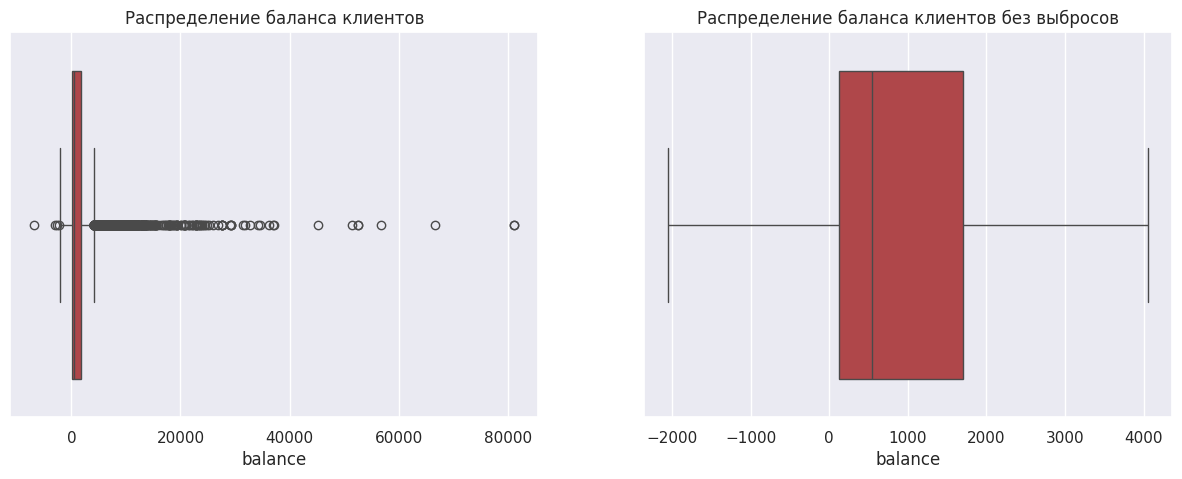

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
sns.boxplot(x=df['balance'],
            ax=axes[0]);
sns.boxplot(x=df['balance'],
            showfliers=False,
            ax=axes[1]);
axes[0].set_title('Распределение баланса клиентов')
axes[1].set_title('Распределение баланса клиентов без выбросов');

In [49]:
def remove_outliers(df, column):
    """
    Удаляет выбросы из указанного столбца DataFrame,
    основываясь на межквартильном диапазоне (IQR).

    :param df: DataFrame, из которого необходимо удалить выбросы
    :param column: Столбец, по которому будет проводиться анализ
    :return: DataFrame без выбросов
    """

    # Вычисление квартилей и межквартильного размаха
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1

    # Определение границ для выбросов
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    print(f'Lower bound: {lower_bound}')
    print(f'Upper bound: {upper_bound}')

    # Фильтрация выбросов
    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    return df

df = remove_outliers(df, 'balance')
# Вывод нового DataFrame без выбросов
print("DataFrame без выбросов:")
print(df.shape[0])

Lower bound: -2241.0
Upper bound: 4063.0
DataFrame без выбросов:
10105


In [54]:
# Функция для преобразования 'yes'/'no' в 1/0
def binary_transform(series):
    return series.map({'yes': 1, 'no': 0})

# Применение функции ко всем нужным столбцам
for col in ['default', 'housing', 'loan', 'deposit']:
    df[col] = binary_transform(df[col])

In [55]:
def categorize_age(df, age_column):
    # Определение границ интервалов и меток
    bins = [0, 25, 35, 45, 60, float('inf')]
    labels = ['age_18_25', 'age_26_35', 'age_36_45', 'age_46_60', 'age_more_60']

    # Использование pd.cut для создания интервалов
    df[age_column] = pd.cut(df[age_column], bins=bins, labels=labels, right=True)

    return df

# Применение функции
df = categorize_age(df, 'age')

Баланс разобьем на отдельные группы:
* 0 - отрицательный баланс
* 1 - баланс до 100
* 2 - баланс от 100 до 250
* 3 - баланс от 251 до 1000
* 4 - баланс от 1001 до 1500
* 5 - баланс свыше 1501

In [57]:
def categorize_balance(df, balance_column):
    # Определение границ интервалов и меток
    bins = [-float('inf'), 0, 100, 250, 1000, 1500, float('inf')]
    labels = [0, 1, 2, 3, 4, 5]  # Метки для каждой категории

    # Использование pd.cut для создания интервалов
    df[balance_column] = pd.cut(df[balance_column], bins=bins, labels=labels, right=False)

    return df
# Применение функции
df = categorize_balance(df, 'balance')

In [62]:
df['pdays'].value_counts()

,count
pdays,
-1,7568
92,88
182,77
181,75
91,74
...,...
440,1
455,1
470,1


Почти все клиенты из данных имели значение в этом признаке равное -1. Что может говорить о том, что с данным клиентом не было контактов в рамках предыдущей маркетинговой кампании. Попробуем изменить признак, присвоив новые значения:
* 1 - если значение больше 0 (контакт был)
* 0 - если значение -1(не было контакта)

In [63]:
df['pdays'] = df['pdays'].apply(lambda row: row != -1)

In [64]:
df.duration.describe()

,duration
count,10105.000000
mean,368.742603
std,346.651524
min,2.000000
25%,137.000000
50%,252.000000
75%,490.000000
max,3881.000000


Для признака durationтакже выделим отдельные группы:
* 0 - длительность до 3 минут
* 1 - длительность от 3 минут до 5
* 2 - длительность от 5 минут до 10
* 3 - длительность более 10 минут

In [69]:
# Функция для присвоения числовых меток
def assign_numeric_labels(duration):
    duration = duration // 60
    if duration < 3:
        return 0
    elif 3 <= duration <= 5:
        return 1
    elif 6 <= duration <= 10:
        return 2
    else:
        return 3

# Применение функции к столбцу duration
df['duration_label'] = df['duration'].apply(assign_numeric_labels)

Признак месяца сделаем числовым для удоства.

In [91]:
dict_month = {
    'jan': 1,
    'feb': 2,
    'mar': 3,
    'apr': 4,
    'may': 5,
    'jun': 6,
    'jul': 7,
    'aug': 8,
    'sep': 9,
    'oct': 10,
    'nov': 11,
    'dec': 12
}

df['month'] = df['month'].map(dict_month)

Заменим признак day на признак, в котором отразим первая или вторая половина месяца.

In [118]:
df['part_of_month'] = df['day'].apply(lambda x: 0 if x <= 16 else 1)

In [121]:
df.drop(['day'], axis=1, inplace=True)

Поработаем с признаками количества контактов с клиентов в текущей и прошлой кампании.

In [86]:
df.previous.value_counts()[:6]

,count
previous,
0,7568
1,796
2,612
3,391
4,223
5,147


В признаке previous преобладают 0 значения, далее встречаются в небольшом количестве 1-2, а признаке больше в данных практически единичны.
Переделаем признак, чтобы он просто отражал был контакт или нет

In [87]:
df['previous'] = df['previous'].apply(lambda row: 0 if row == 0 else 1)

In [88]:
df.campaign.value_counts()[:8]

,count
campaign,
1,4331
2,2749
3,1192
4,696
5,347
6,239
7,126
8,117


In [89]:
df['campaign'] = df['campaign'].apply(lambda row: 1 if row == 1 else (2 if row == 2 or row == 3 else 3))

## Изучим, какие признаки влияют на целевую переменную, а также оценим их распределение.

### Для начала оценим целевую переменную на наличие дисбаланса классов

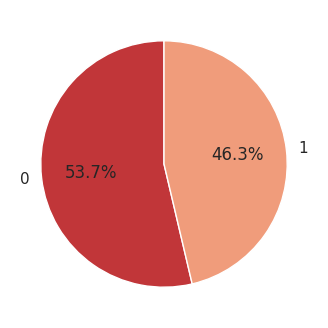

In [ ]:
# Вычисление долей для каждого значения
deposit_counts = df['deposit'].value_counts()

# Создание круговой диаграммы
plt.figure(figsize=(4, 4))
plt.pie(deposit_counts,
        labels=deposit_counts.index,
        autopct='%1.1f%%',
        startangle=90
        );


Дисбаланс классов в наших данных не наблюдается.

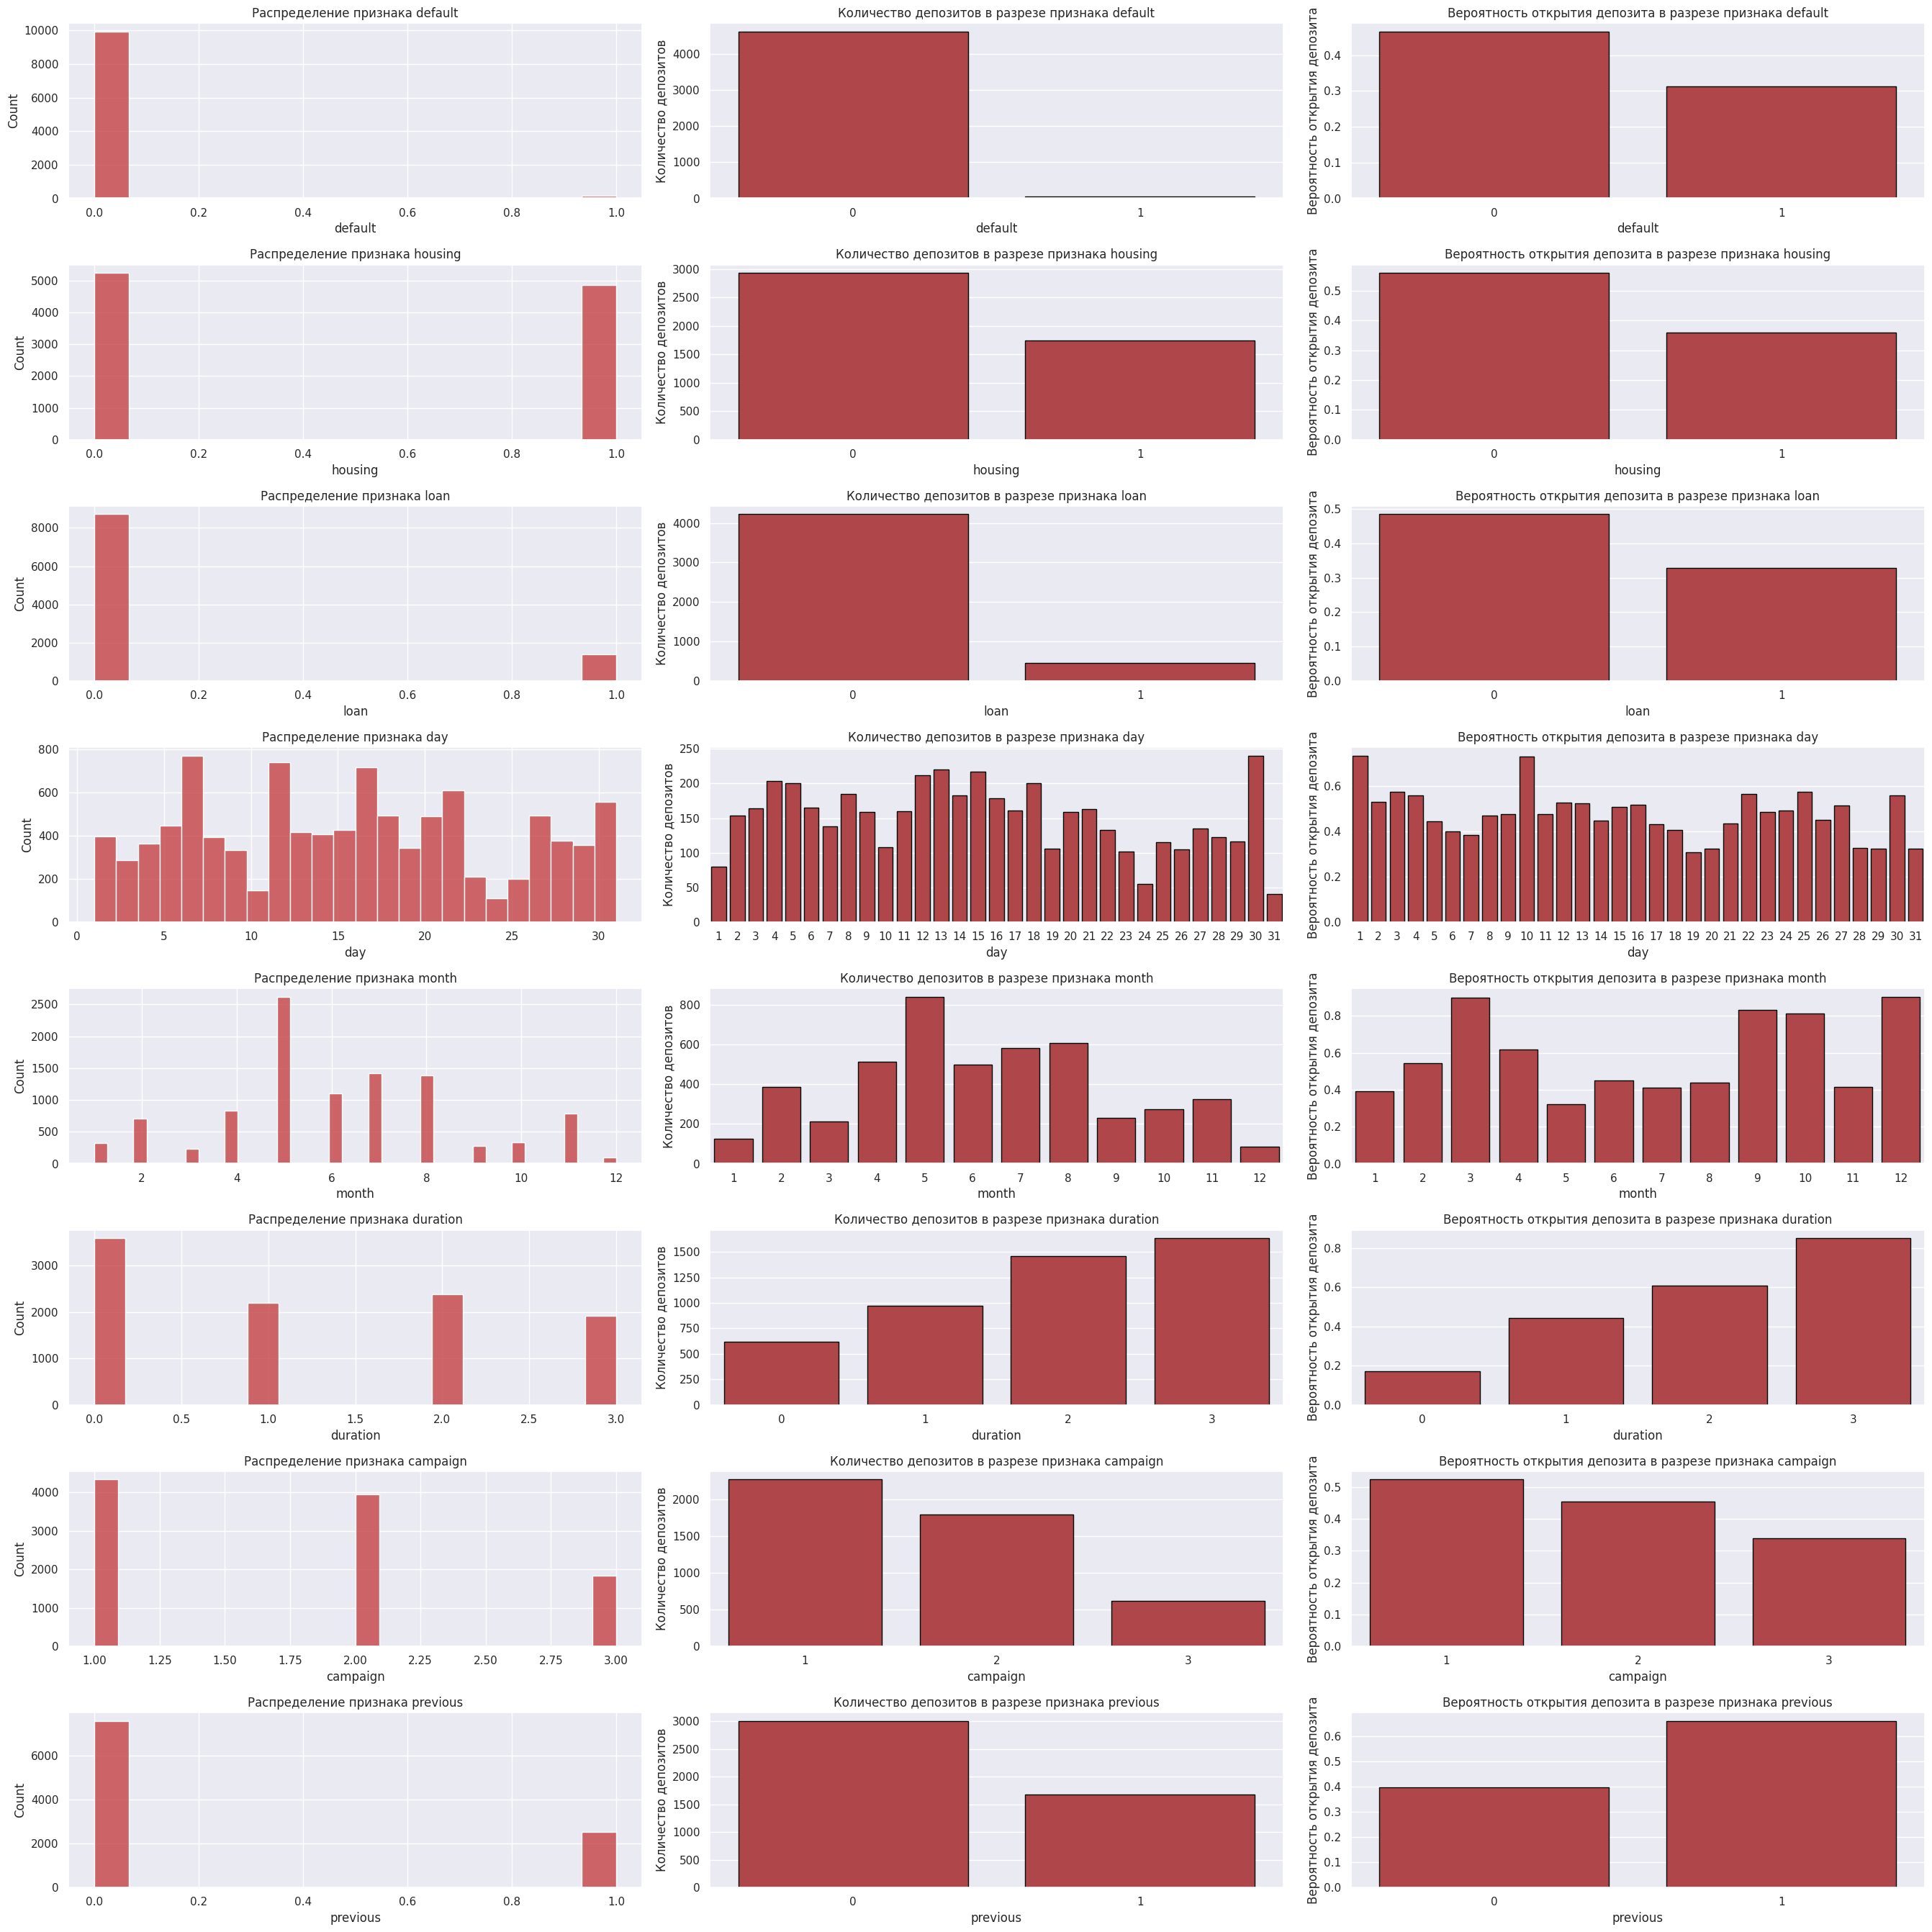

In [92]:
# Удаляем столбец 'deposit' и выбираем только числовые столбцы
columns = df.drop(['deposit'], axis=1).select_dtypes(include=[int, float])

# Создаем подграфики
fig, axes = plt.subplots(columns.shape[1], 3, figsize=(27, 27))

# Иерация по каждому числовому столбцу
for i, column in enumerate(columns):
    # Группировка данных по значению признака и подсчет сумм и среднего значения
    pd_df = df.groupby(column)['deposit'].agg(['sum', 'mean']).reset_index()

    # Боксовая диаграмма
    sns.histplot(x=df[column], ax=axes[i][0])
    axes[i][0].set_title(f'Распределение признака {column}')

    # Столбчатая диаграмма количества депозитов
    sns.barplot(data=pd_df, x=column, y='sum', edgecolor='black', ax=axes[i][1])
    axes[i][1].set_xlabel(f'{column}')
    axes[i][1].set_ylabel('Количество депозитов')
    axes[i][1].set_title(f'Количество депозитов в разрезе признака {column}')

    # Столбчатая диаграмма вероятности открытия депозита
    sns.barplot(data=pd_df, x=column, y='mean', edgecolor='black', ax=axes[i][2])
    axes[i][2].set_xlabel(f'{column}')
    axes[i][2].set_ylabel('Вероятность открытия депозита')
    axes[i][2].set_title(f'Вероятность открытия депозита в разрезе признака {column}')

# Применение автоматической настройки графиков
plt.tight_layout()
plt.show()

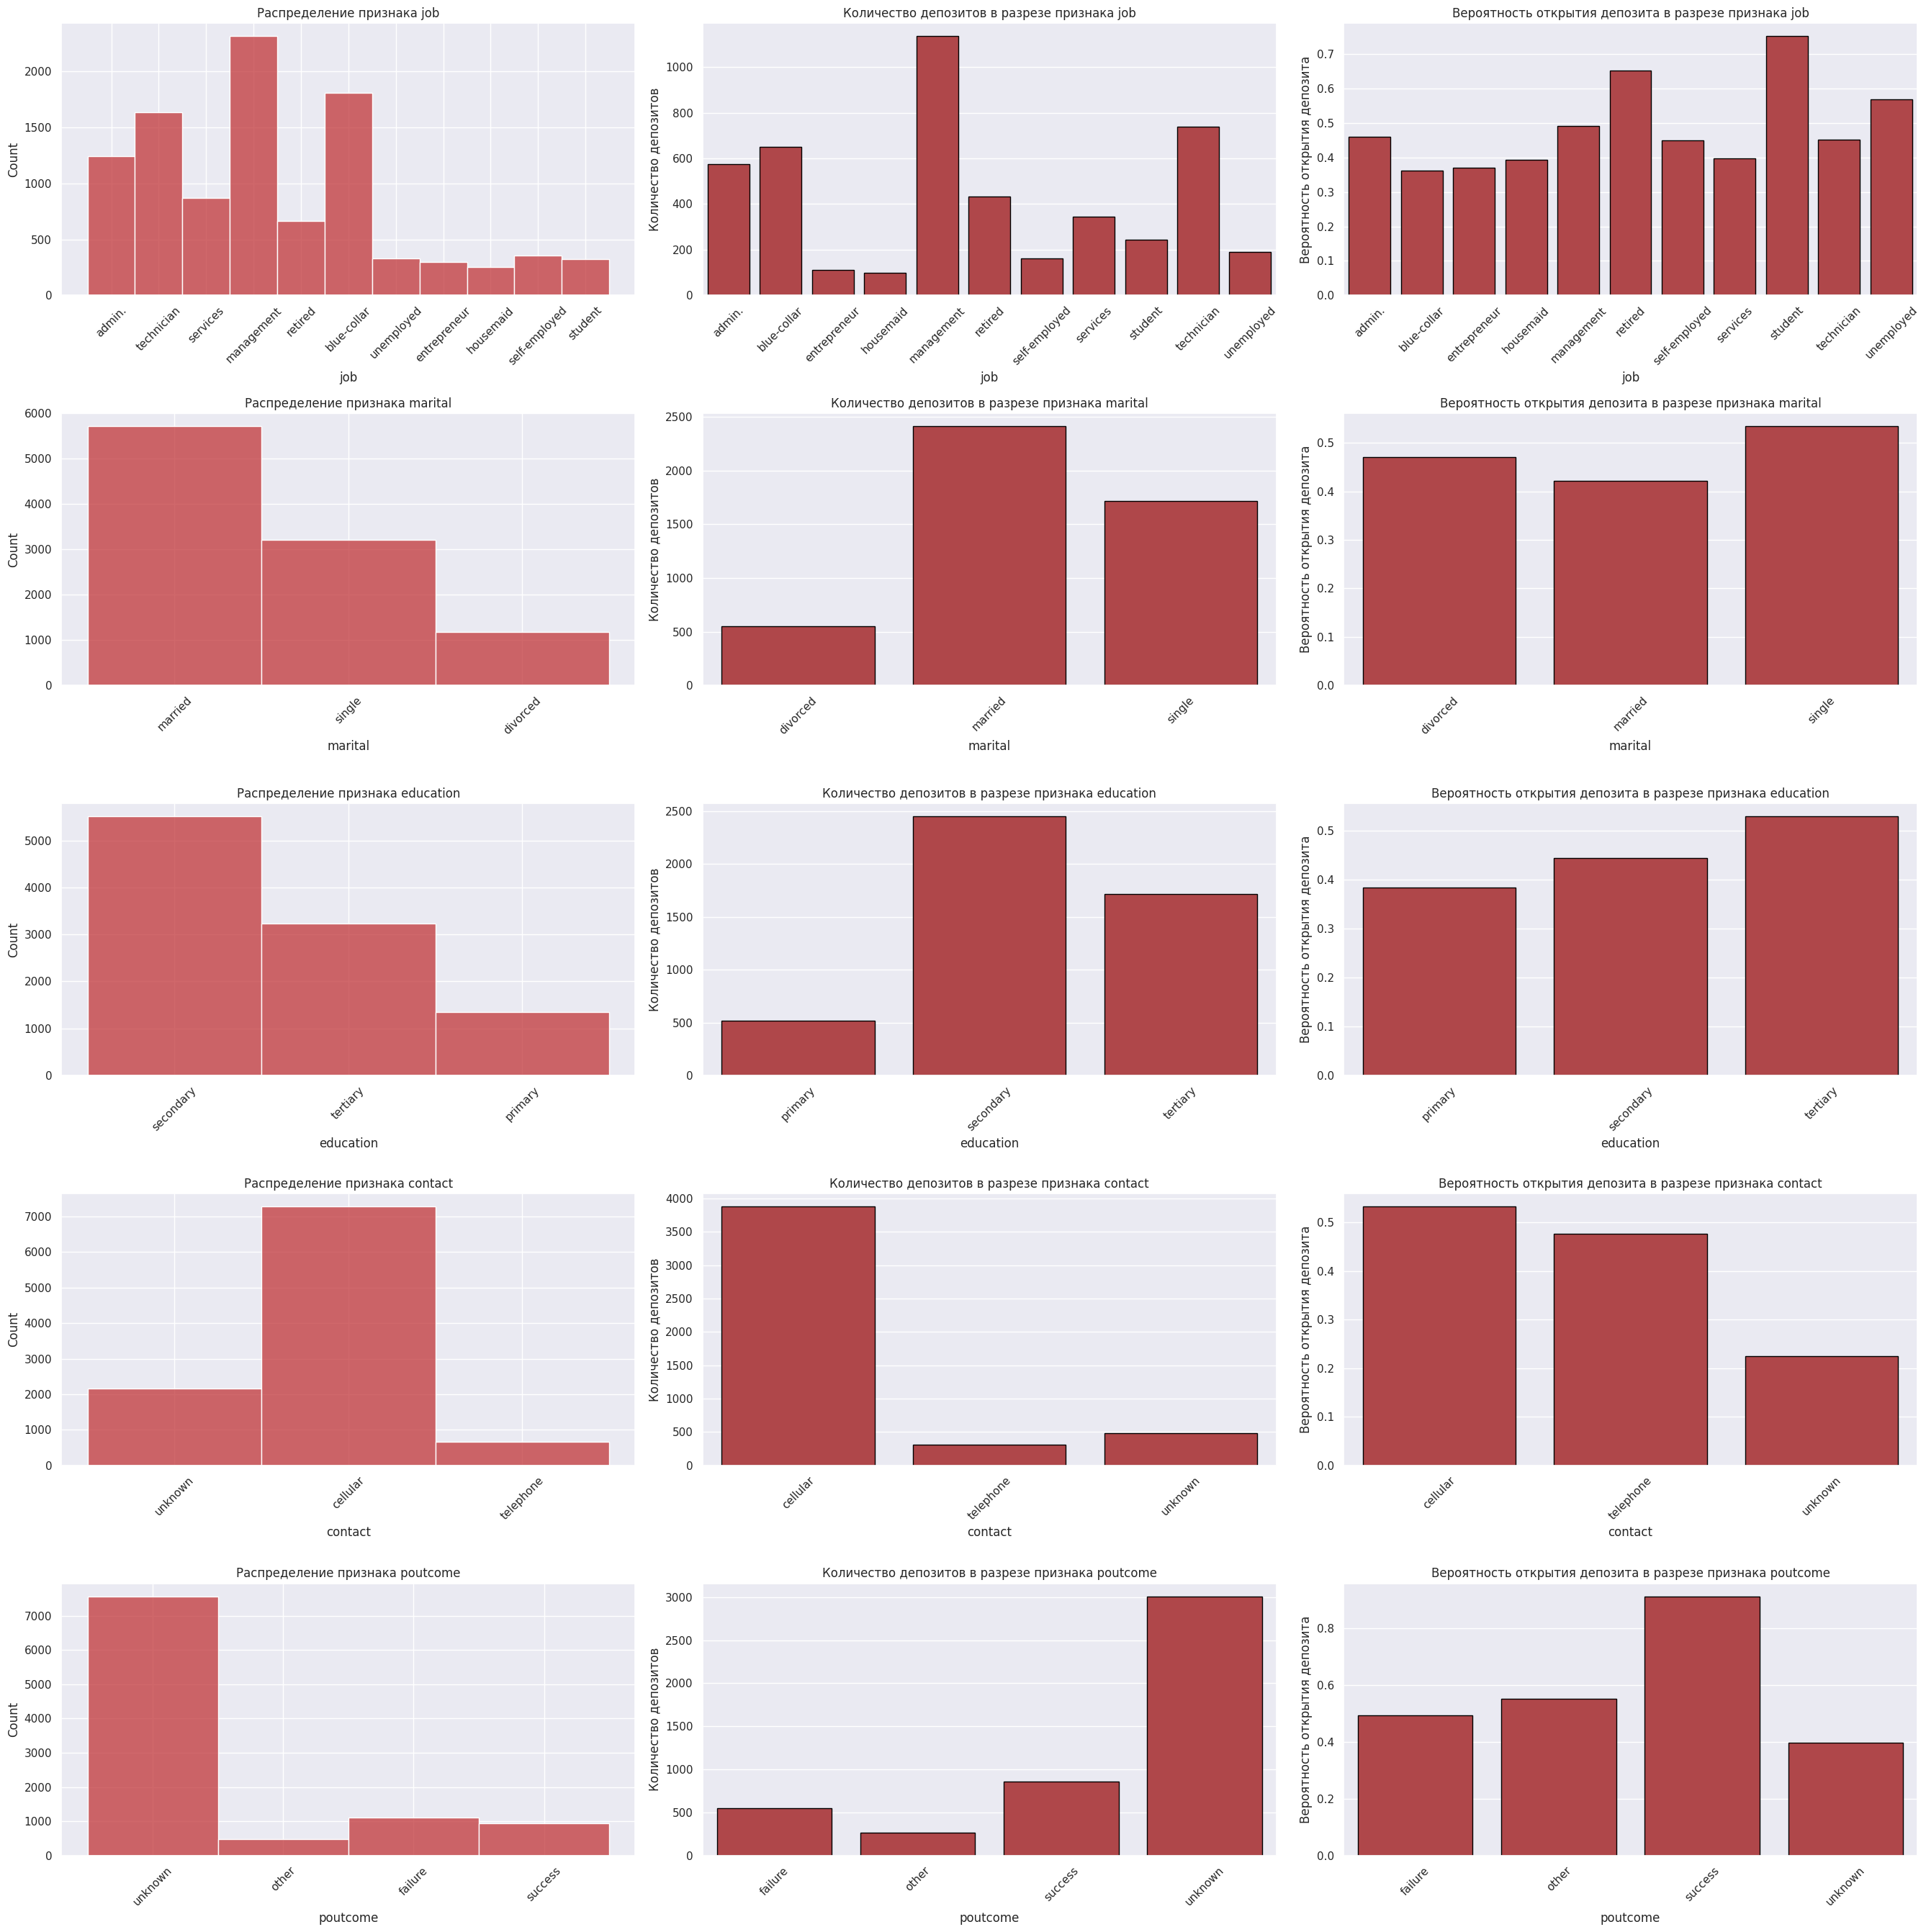

In [122]:
columns = df.drop(['deposit'], axis=1).select_dtypes(include=[object])

# Создаем подграфики
fig, axes = plt.subplots(columns.shape[1], 3, figsize=(27, 27))

# Иерация по каждому числовому столбцу
for i, column in enumerate(columns):
    # Группировка данных по значению признака и подсчет сумм и среднего значения
    pd_df = df.groupby(column)['deposit'].agg(['sum', 'mean']).reset_index()

    # Боксовая диаграмма
    sns.histplot(x=df[column], ax=axes[i][0])
    axes[i][0].set_title(f'Распределение признака {column}')
    axes[i][0].tick_params(axis='x', rotation=45)
    # Столбчатая диаграмма количества депозитов
    sns.barplot(data=pd_df, x=column, y='sum', edgecolor='black', ax=axes[i][1])
    axes[i][1].set_xlabel(f'{column}')
    axes[i][1].set_ylabel('Количество депозитов')
    axes[i][1].set_title(f'Количество депозитов в разрезе признака {column}')
    axes[i][1].tick_params(axis='x', rotation=45)
    # Столбчатая диаграмма вероятности открытия депозита
    sns.barplot(data=pd_df, x=column, y='mean', edgecolor='black', ax=axes[i][2])
    axes[i][2].set_xlabel(f'{column}')
    axes[i][2].set_ylabel('Вероятность открытия депозита')
    axes[i][2].set_title(f'Вероятность открытия депозита в разрезе признака {column}')
    axes[i][2].tick_params(axis='x', rotation=45)
# Применение автоматической настройки графиков
plt.tight_layout()
plt.show()

## **Гипотезы**
**Баланс клиента и вероятность открытия депозита**
- Чем выше значение баланса клиента, тем выше вероятность открытия им депозита.

**Влияние ипотеки и кредитов на депозит**
- Наличие ипотеки снижает вероятность открытия депозита, точно так же как и просто наличие кредита у клиента.

**Сезонность открытия депозитов**
- Самыми удачными месяцами по вероятности открытия депозита являются март, сентябрь, октябрь и декабрь.

**Продолжительность контакта с клиентом**
- Чем более продолжительный был контакт с клиентом, тем выше вероятность открытия им депозита.

**Роль предыдущих контактов в кампаниях**
- В рамках текущей и прошлой кампании также играет роль, был ли в прошлом контакт с клиентом.

**Канал связи и открытие депозита**
- Депозиты чаще всего открывали клиенты, с которыми общались по мобильному телефону.

**Уровень образования и лояльность**
- Клиенты с высшим образованием проявляли наибольшую лояльность.

**Статус и открытие депозита**
- Чаще всего депозиты открывали одинокие люди.

**Возраст и вероятность открытия депозита**
- На вероятность открытия депозита также влиял возраст: наиболее лояльными были как молодые люди до 25 лет, так и пожилые люди старше 60 лет.

## Часть 3: Проверка гипотез и создание новых признаков

### С учетом того, что у нас есть одна категориальная переменная (категория баланса) и одна бинарная целевая переменная (открытие депозита: 0 - не открыл, 1 - открыл), можно использовать тест хи-квадрат для проверки зависимости между двумя категориальными переменными.

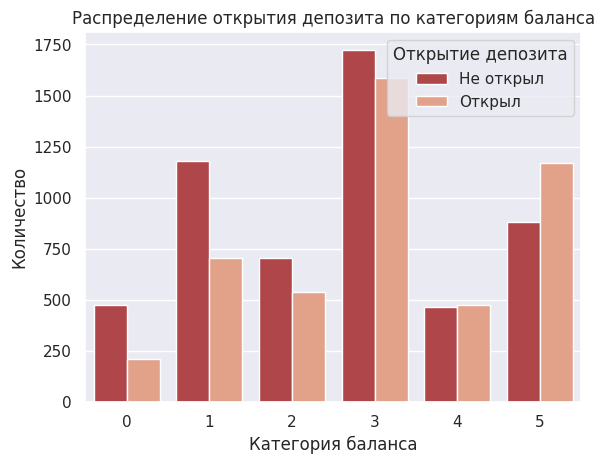

Тест хи-квадрат: статистика = 239.02326931261297, p-значение = 0.0


In [123]:
# Визуализация распределения
sns.countplot(x='balance', hue='deposit', data=df)
plt.title('Распределение открытия депозита по категориям баланса')
plt.xlabel('Категория баланса')
plt.ylabel('Количество')
plt.legend(title='Открытие депозита', loc='upper right', labels=['Не открыл', 'Открыл'])
plt.show()

# Проведение теста хи-квадрат
contingency_table = pd.crosstab(df['balance'], df['deposit'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Тест хи-квадрат: статистика = {chi2}, p-значение = {round(p, 6)}")

### Для проверки следующей гипотезы сначала объединим 2 признака в один(наличие ипотеки и наличие кредита). Новый признак будет содержать в себе сумму кредитов, тем самым можно будет отразить есть ли у клиента 1 кредит, 2 кредита или вообще никаких кредитов.

In [124]:
print(f"Корреляция ипотеки с целевым признаком - {df[['housing', 'deposit']].corr().iloc[0, 1].round(3)}")
print(f"Корреляция наличия кредита с целевым признаком - {df[['loan', 'deposit']].corr().iloc[0, 1].round(3)}")

Корреляция ипотеки с целевым признаком - -0.2
Корреляция наличия кредита с целевым признаком - -0.107


In [125]:
df['credits'] = df['loan'] + df['housing']
print(f"Корреляция объединенного признака с целевым признаком - {df[['credits', 'deposit']].corr().iloc[0, 1].round(3)}")

Корреляция объединенного признака с целевым признаком - -0.219


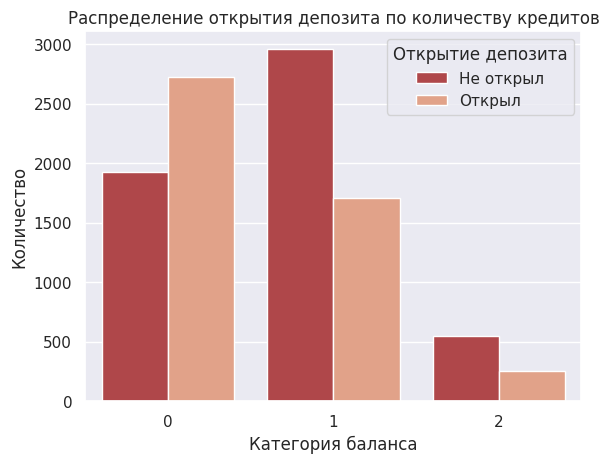

In [126]:
# Визуализация распределения
sns.countplot(x='credits', hue='deposit', data=df)
plt.title('Распределение открытия депозита по количеству кредитов')
plt.xlabel('Категория баланса')
plt.ylabel('Количество')
plt.legend(title='Открытие депозита', loc='upper right', labels=['Не открыл', 'Открыл'])
plt.show()


In [127]:
# Разделение на группы
groups = df.groupby('credits')['deposit'].apply(list)

# Проверка нормальности для каждой группы
for credit_amount, deposits in groups.items():
    stat, p_value = shapiro(deposits)
    print(f'Кредиты: {credit_amount} - Статистика: {stat}, p-значение: {round(p_value, 3)}')

# Проведение ANOVA
anova_data = [deposits for deposits in groups]
stats, p_value = f_oneway(*anova_data)

print(f"ANOVA статистика: {stats}, p-значение: {round(p_value, 3)}")

Кредиты: 0 - Статистика: 0.625647484924885, p-значение: 0.0
Кредиты: 1 - Статистика: 0.6098331890957529, p-значение: 0.0
Кредиты: 2 - Статистика: 0.5849603408299039, p-значение: 0.0
ANOVA статистика: 281.0696562321461, p-значение: 0.0


### Так как самыми удачными месяцами по вероятности открытия депозита являются - март, сентябрь, октябрь и декабрь, а самым неудачным май. Немного скорректируем наш признак month. Теперь в нем будет храниться категория (0 - если месяц неудачный(май), 2 - если месяц из списка удачных и 1 для всех остальных)


In [128]:
df['month'] = df['month'].apply(lambda x: 2 if x in [3,9,10,12] else (0 if x == 5 else 1))

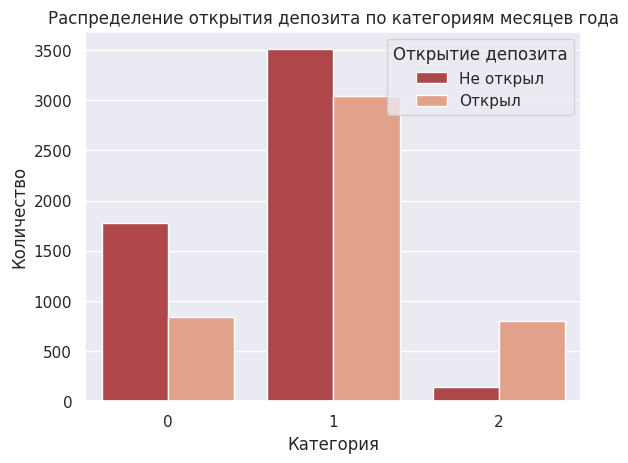

Тест хи-квадрат: статистика = 780.5833600843134, p-значение = 0.0


In [129]:
# Визуализация распределения
sns.countplot(x='month', hue='deposit', data=df)
plt.title('Распределение открытия депозита по категориям месяцев года')
plt.xlabel('Категория')
plt.ylabel('Количество')
plt.legend(title='Открытие депозита', loc='upper right', labels=['Не открыл', 'Открыл'])
plt.show()

# Проведение теста хи-квадрат
contingency_table = pd.crosstab(df['month'], df['deposit'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Тест хи-квадрат: статистика = {chi2}, p-значение = {round(p, 6)}")

### Проверим действительно ли есть статистически значимая разница между клиентами, открывшими депозит и не открывшими в зависимости от длительности контакта

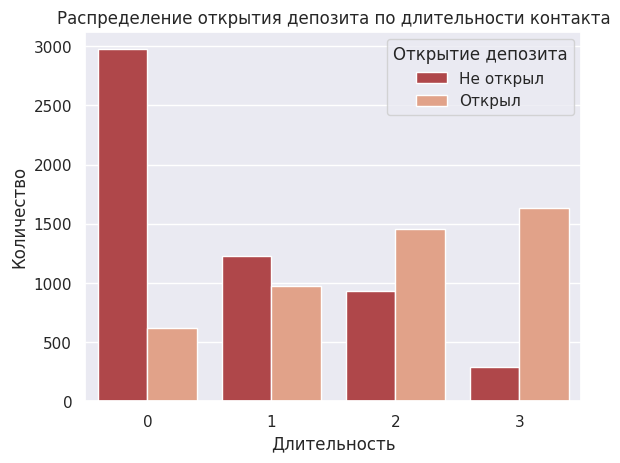

In [130]:
# Визуализация распределения
sns.countplot(x='duration', hue='deposit', data=df)
plt.title('Распределение открытия депозита по длительности контакта')
plt.xlabel('Длительность')
plt.ylabel('Количество')
plt.legend(title='Открытие депозита', loc='upper right', labels=['Не открыл', 'Открыл'])
plt.show()


In [131]:
# Разделение на группы
groups = df.groupby('duration')['deposit'].apply(list)

# Проверка нормальности для каждой группы
for dur, deposits in groups.items():
    stat, p_value = shapiro(deposits)
    print(f'Категория по длительности: {dur} - Статистика: {stat}, p-значение: {round(p_value, 3)}')

# Проведение ANOVA
anova_data = [duration for duration in groups]
stats, p_value = f_oneway(*anova_data)

print(f"ANOVA статистика: {stats}, p-значение: {round(p_value, 3)}")

Категория по длительности: 0 - Статистика: 0.4557957537195455, p-значение: 0.0
Категория по длительности: 1 - Статистика: 0.6317613538997758, p-значение: 0.0
Категория по длительности: 2 - Статистика: 0.6189048709998535, p-значение: 0.0
Категория по длительности: 3 - Статистика: 0.42608593462536304, p-значение: 0.0
ANOVA статистика: 1163.9627864255076, p-значение: 0.0


### Оценим значимость признака типа контакт с клиентом.


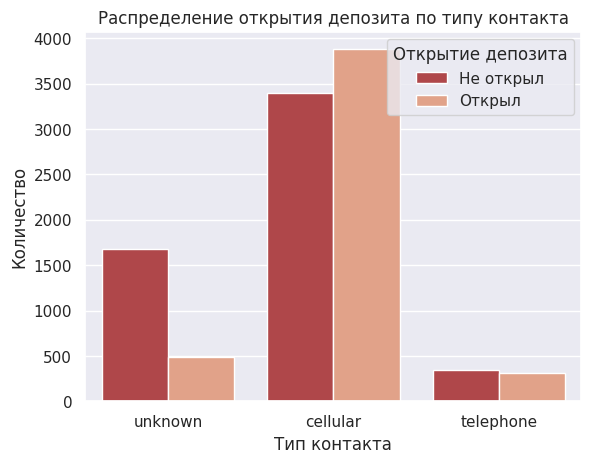

Тест хи-квадрат: статистика = 635.6981023175712, p-значение = 0.0


In [134]:
# Визуализация распределения
sns.countplot(x='contact', hue='deposit', data=df)
plt.title('Распределение открытия депозита по типу контакта')
plt.xlabel('Тип контакта')
plt.ylabel('Количество')
plt.legend(title='Открытие депозита', loc='upper right', labels=['Не открыл', 'Открыл'])
plt.show()

# Проведение теста хи-квадрат
contingency_table = pd.crosstab(df['contact'], df['deposit'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Тест хи-квадрат: статистика = {chi2}, p-значение = {round(p, 6)}")

### Действительно ли есть статистическая значимость признака education.
Н0 - Количетсво лояльных и нелояльных клиентов одинаково во всех группах
Н1 - Количество лояльных и нелояльных клиентов различаются в разных группах.

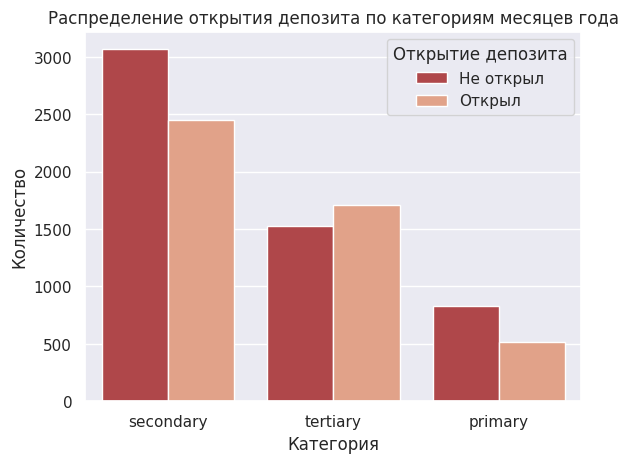

Тест хи-квадрат: статистика = 98.80992923515059, p-значение = 0.0


In [137]:
# Визуализация распределения
sns.countplot(x='education', hue='deposit', data=df)
plt.title('Распределение открытия депозита по уровню образования')
plt.xlabel('Уровень образования')
plt.ylabel('Количество')
plt.legend(title='Открытие депозита', loc='upper right', labels=['Не открыл', 'Открыл'])
plt.show()

# Проведение теста хи-квадрат
contingency_table = pd.crosstab(df['education'], df['deposit'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Тест хи-квадрат: статистика = {chi2}, p-значение = {round(p, 6)}")

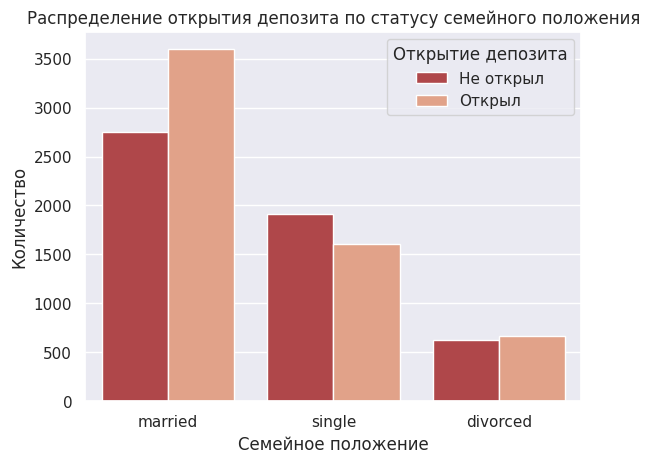

Тест хи-квадрат: статистика = 109.58335610012479, p-значение = 0.0


In [244]:
# Визуализация распределения
sns.countplot(x='marital', hue='deposit', data=df)
plt.title('Распределение открытия депозита по статусу семейного положения')
plt.xlabel('Семейное положение')
plt.ylabel('Количество')
plt.legend(title='Открытие депозита', loc='upper right', labels=['Не открыл', 'Открыл'])
plt.show()

# Проведение теста хи-квадрат
contingency_table = pd.crosstab(df['marital'], df['deposit'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Тест хи-квадрат: статистика = {chi2}, p-значение = {round(p, 6)}")

In [139]:
list(df.job.unique())

['admin.',
 'technician',
 'services',
 'management',
 'retired',
 'blue-collar',
 'unemployed',
 'entrepreneur',
 'housemaid',
 'self-employed',
 'student']

Изучив признак job, можно увидеть, что там не только указывается профессия, но и статус клиента (студент, пенсионер и безработный)
Создадим отдельные признаки:
* Явлется студентом
* Является пенсионером
* Является безработным
* Имеет ли работу


In [150]:
df['is_student'] = df['job'].apply(lambda x: x =='student')
df['is_unemployed'] = df['job'].apply(lambda x: x =='unemployed')
df['is_retired'] = df['job'].apply(lambda x: x =='retired')
df['with_job'] = df['job'].apply(lambda x: x != 'student' and x != 'retired' and x != 'unemployed')

# Создание переменных для ANOVA
student_deposit = df[df['is_student']]['deposit']
unemployed_deposit = df[df['is_unemployed']]['deposit']
retired_deposit = df[df['is_retired']]['deposit']
with_job_deposit = df[df['with_job']]['deposit']

# Функция для проверки нормальности
def check_normality(data):
    stat, p_value = shapiro(data)
    print(f'Statistics: {stat}, p-value: {p_value}')
    if p_value > 0.05:
        print('Данные нормально распределены (не отклоняем гипотезу H0).')
    else:
        print('Данные не нормально распределены (отклоняем гипотезу H0).')

# Проверка нормальности для каждой группы
print("Студенты:")
check_normality(student_deposit)
print("\nБезработные:")
check_normality(unemployed_deposit)
print("\nПенсионеры:")
check_normality(retired_deposit)
print("\nС работающими:")
check_normality(with_job_deposit)
print()
# Проверка различий между группами с помощью теста Краскала-Уоллиса
stat, p_value = kruskal(student_deposit, unemployed_deposit, retired_deposit, with_job_deposit)

print(f'Statistics: {stat}, p-value: {p_value}')
alpha = 0.05
if p_value < alpha:
    print("Имеются статистически значимые различия между группами.")
else:
    print("Нет оснований отклонить нулевую гипотезу о равенстве средних.")

Студенты:
Statistics: 0.5370701762856216, p-value: 2.0353014765056356e-28
Данные не нормально распределены (отклоняем гипотезу H0).

Безработные:
Statistics: 0.6294799467220934, p-value: 3.611096698375484e-26
Данные не нормально распределены (отклоняем гипотезу H0).

Пенсионеры:
Statistics: 0.6022507383715758, p-value: 2.3041143047154543e-36
Данные не нормально распределены (отклоняем гипотезу H0).

С работающими:
Statistics: 0.6303225065402998, p-value: 3.615461400872876e-87
Данные не нормально распределены (отклоняем гипотезу H0).

Statistics: 248.10588149540052, p-value: 1.6807028595284325e-53
Имеются статистически значимые различия между группами.


In [151]:
df.drop('job', axis=1, inplace=True)

### Теперь оценим признак возрастных категорий

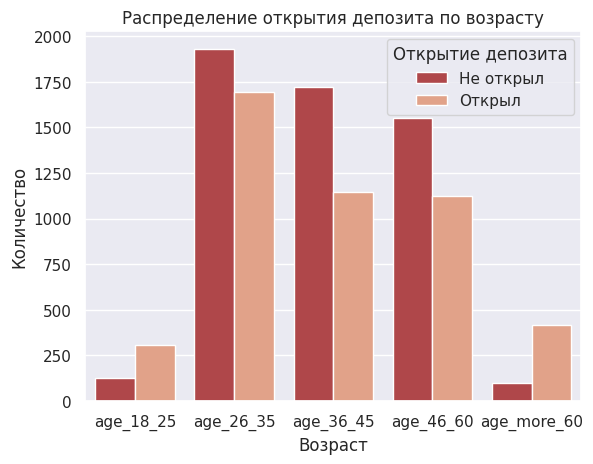

Тест хи-квадрат: статистика = 420.91294288617826, p-значение = 0.0


In [153]:
# Визуализация распределения
sns.countplot(x='age', hue='deposit', data=df)
plt.title('Распределение открытия депозита по возрасту')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.legend(title='Открытие депозита', loc='upper right', labels=['Не открыл', 'Открыл'])
plt.show()

# Проведение теста хи-квадрат
contingency_table = pd.crosstab(df['age'], df['deposit'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Тест хи-квадрат: статистика = {chi2}, p-значение = {round(p, 6)}")

## Переходим к кодированию переменных, оценки корреляции между признаками

In [154]:
# Инициализация LabelEncoder
le = LabelEncoder()

# Применение LabelEncoder к столбцу 'education'
df['education_encoded'] = le.fit_transform(df['education'])

In [156]:
df.drop('education', axis=1, inplace=True)

In [158]:
print(df.shape)
df = pd.get_dummies(df, columns=['marital', 'contact', 'poutcome', 'age'], drop_first=True)
print(df.shape)

(10105, 21)
(10105, 28)


In [159]:
df.drop('poutcome_unknown', axis=1, inplace=True)

In [160]:
df.drop(['housing', 'loan'], axis=1, inplace=True)

<Axes: >

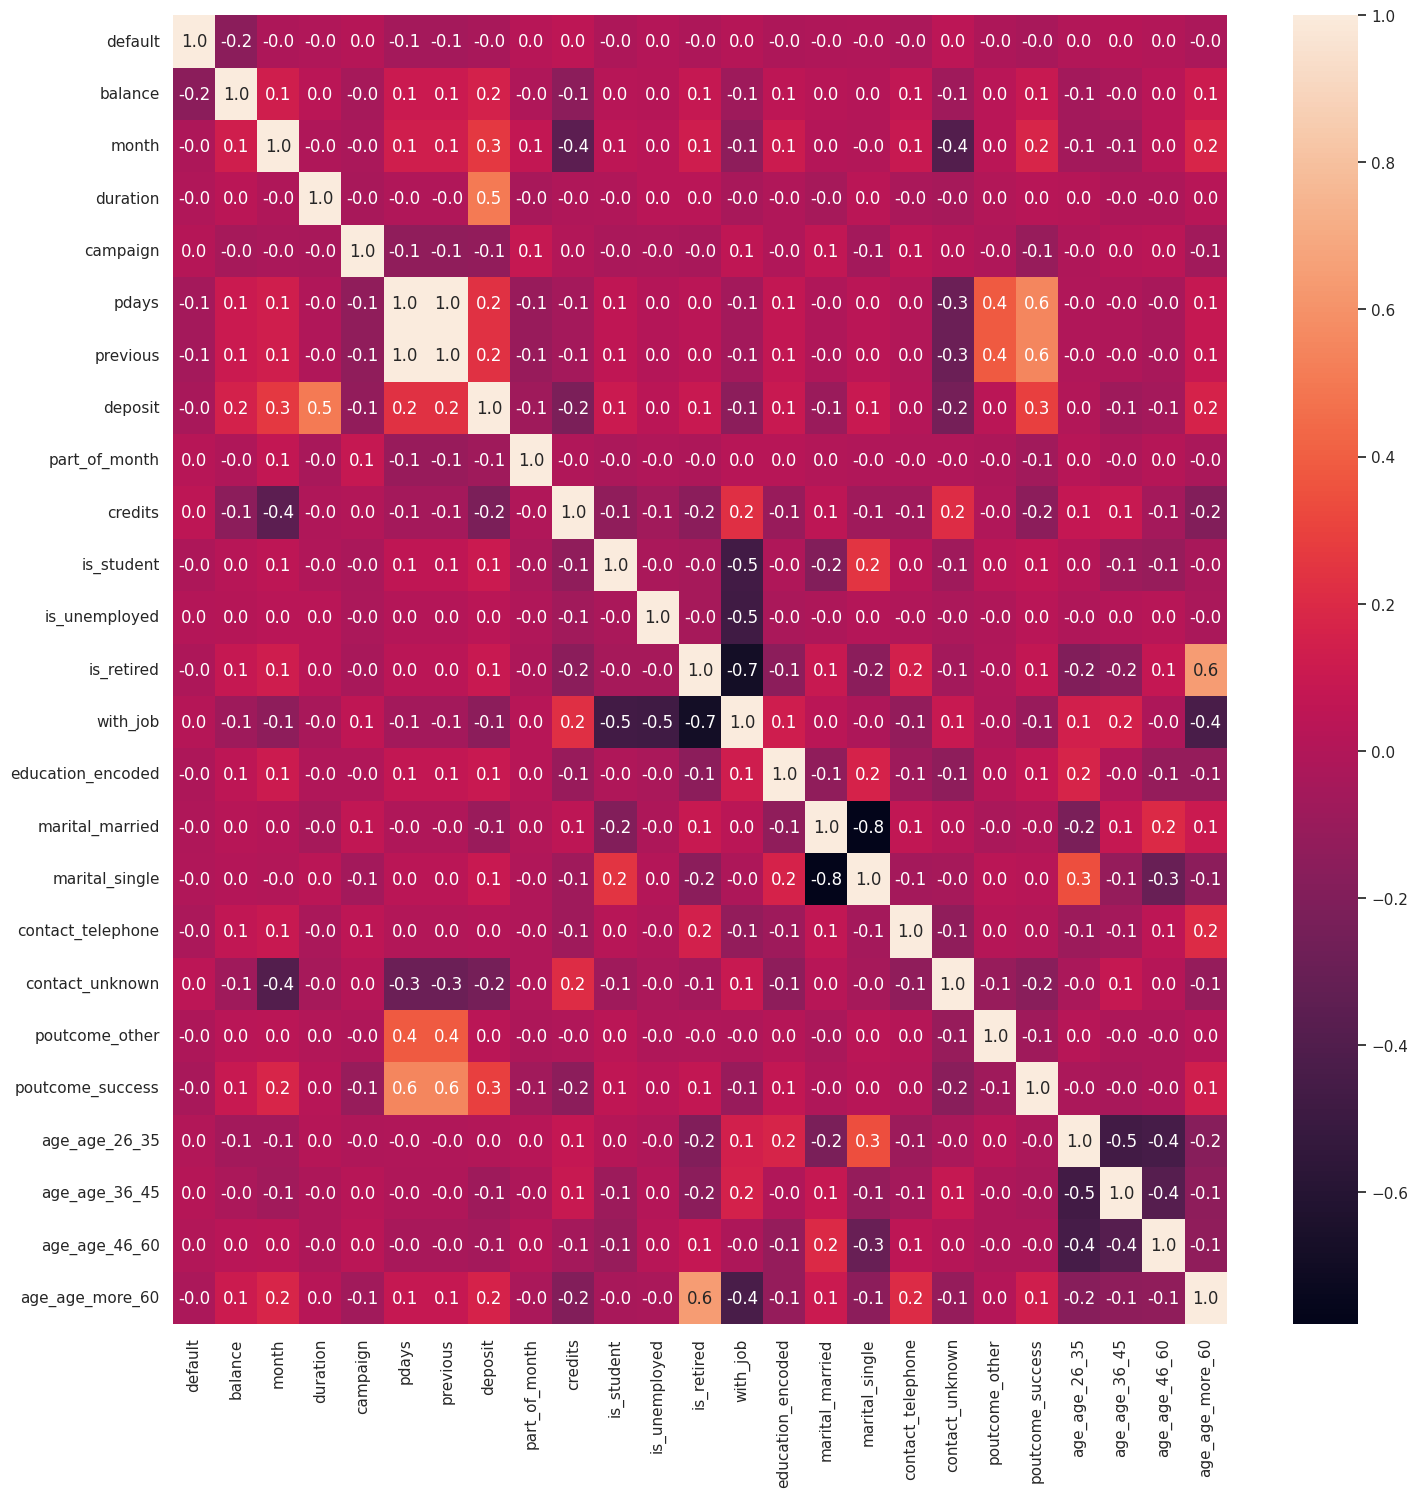

In [162]:
fig, ax = plt.subplots(figsize=(17,17))
sns.heatmap(df.corr(), annot=True,fmt='.1f')


In [163]:
df.drop(['pdays', 'is_retired'], axis=1, inplace=True)

### Переходим к отбору признаков и нормализации данных

In [164]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

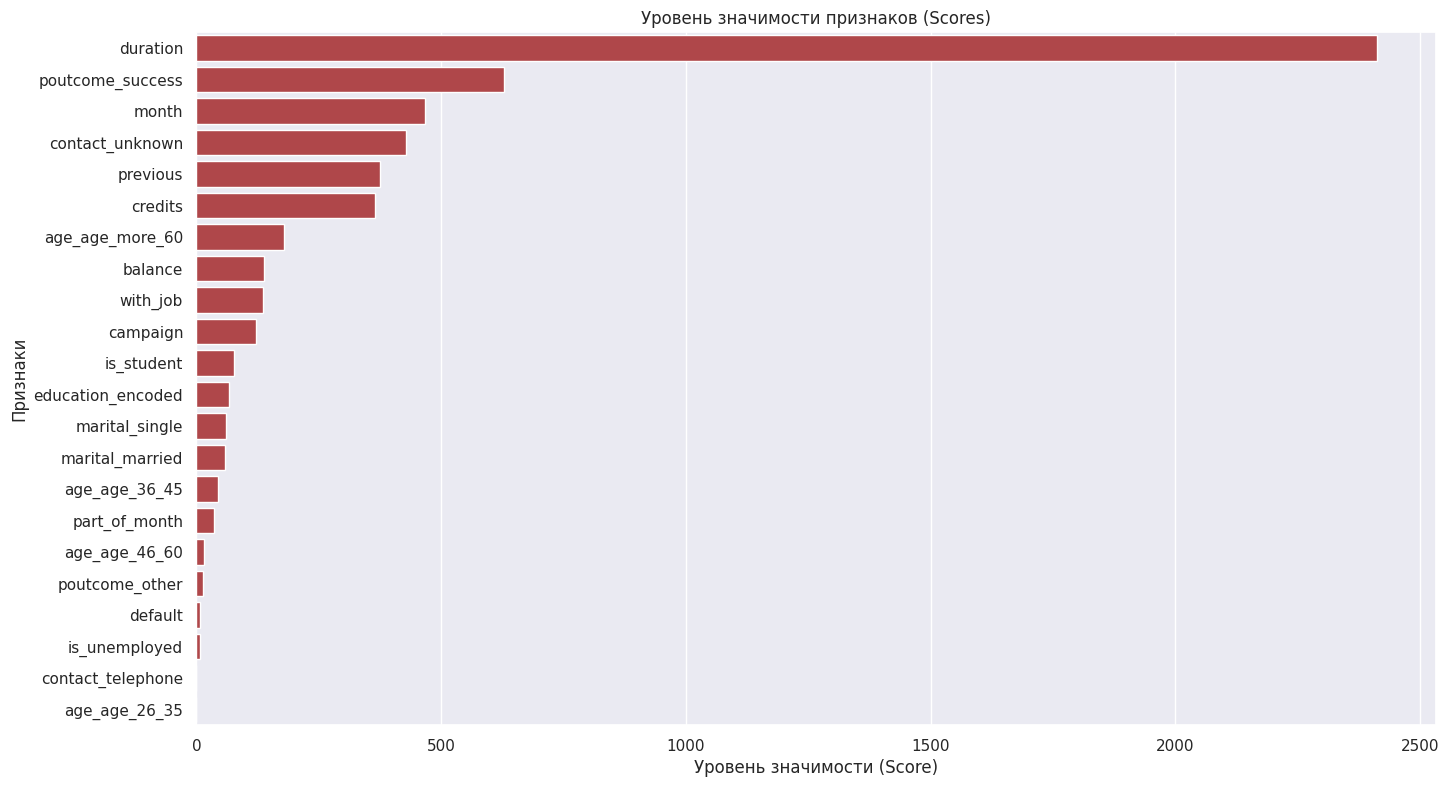

In [171]:
X_train_numeric = X_train
# Инициализация SelectKBest
selector = SelectKBest(score_func=f_classif, k=22)

# Фитируем на обучающей выборке
X_train_selected = selector.fit_transform(X_train_numeric, y_train)

# Получаем маску для выбранных признаков
mask = selector.get_support()

# Получаем имена выбранных признаков
selected_features = X_train_numeric.columns[mask]

# Получаем оценки (scores)
scores = selector.scores_

# Создание DataFrame для удобной работы с оценками
feature_scores = pd.DataFrame({'Feature': X_train_numeric.columns, 'Score': scores})

# Фильтрация для выбранных признаков
feature_scores = feature_scores[feature_scores['Feature'].isin(selected_features)]

# Сортировка по оценкам
feature_scores = feature_scores.sort_values(by='Score', ascending=False)

# Визуализация
plt.figure(figsize=(16, 9))
sns.barplot(x='Score', y='Feature', data=feature_scores)
plt.title('Уровень значимости признаков (Scores)')
plt.xlabel('Уровень значимости (Score)')
plt.ylabel('Признаки')
plt.show()

In [174]:
selected_features = list(selected_features)
selected_features.remove('contact_telephone')
selected_features.remove('age_age_26_35')

## Нормализуем данные

In [175]:
X_train = X_train[selected_features]
X_test = X_test[selected_features]
# Инициализация MinMaxScaler
scaler = MinMaxScaler()

columnstr=X_train.columns
columnst=X_test.columns

# Фит и трансформация обучающей выборки
X_train = scaler.fit_transform(X_train)

# Трансформация тестовой выборки (без вызова fit)
X_test = scaler.transform(X_test)

# Преобразуйте обратно в DataFrame для удобства
X_train = pd.DataFrame(X_train, columns=columnstr)
X_test = pd.DataFrame(X_test, columns=columnst)


# Решение задачи классификации: логистическая регрессия и решающие деревья.

# Логистическая регрессия

In [179]:
# Инициализация логистической регрессии
log_reg = LogisticRegression(random_state=42)

# Обучение модели
log_reg.fit(X_train, y_train)

# Прогнозы на тестовой выборке
y_pred = log_reg.predict(X_test)

# Оценка качества модели
accuracy = accuracy_score(y_test, y_pred)
rocauc = roc_auc_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Вывод результатов
print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')
print(f'Roc AUC :\n{rocauc}')

Accuracy: 0.8032983508245877
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.82      0.82      1790
           1       0.79      0.79      0.79      1545

    accuracy                           0.80      3335
   macro avg       0.80      0.80      0.80      3335
weighted avg       0.80      0.80      0.80      3335

Roc AUC :
0.8023639059138327


In [184]:
# Установка параметров для GridSearch
param_grid = {
    'C': [0.01, 0.1, 1, 10],  # Обратная регуляризационная сила
    'penalty': ['l2'],  # L2 регуляризация
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],  # Методы оптимизации
}

# Инициализация логистической регрессии
logistic_regression = LogisticRegression(random_state=42)

# Инициализация GridSearchCV
grid_search_log = GridSearchCV(estimator=logistic_regression, param_grid=param_grid, scoring='roc_auc', cv=5)

# Обучение модели
grid_search_log.fit(X_train, y_train)

# Достаем лучшие параметры
print(f'Лучшие параметры: {grid_search_log.best_params_}')

# Достаем лучшую модель
best_model_log = grid_search_log.best_estimator_

# Прогнозы на тестовой выборке с лучшей моделью
y_pred_best_log = best_model_log.predict(X_test)

# Оценка качества модели
accuracy_best_log = accuracy_score(y_test, y_pred_best_log)
rocauc_best_log = roc_auc_score(y_test, y_pred_best_log)
report_best_log = classification_report(y_test, y_pred_best_log)

# Вывод результатов
print(f'Accuracy of Best Logistic Regression: {accuracy_best_log}')
print(f'Classification Report of Best Logistic Regression:\n{report_best_log}')
print(f'Roc AUC :\n{rocauc_best_log}')

Лучшие параметры: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
Accuracy of Best Logistic Regression: 0.8038980509745127
Classification Report of Best Logistic Regression:
              precision    recall  f1-score   support

           0       0.82      0.82      0.82      1790
           1       0.79      0.79      0.79      1545

    accuracy                           0.80      3335
   macro avg       0.80      0.80      0.80      3335
weighted avg       0.80      0.80      0.80      3335

Roc AUC :
0.8029225651317098


# Решающие деревья

In [186]:
# Инициализация решающего дерева
decision_tree = DecisionTreeClassifier(random_state=42)

# Обучение модели
decision_tree.fit(X_train, y_train)
# Прогнозы на тестовой выборке
y_pred_tree = decision_tree.predict(X_test)

# Оценка качества модели
accuracy_tree = accuracy_score(y_test, y_pred_tree)
report_tree = classification_report(y_test, y_pred_tree)

# Вывод результатов
print(f'Accuracy of Decision Tree: {accuracy_tree}')
print(f'Classification Report of Decision Tree:\n{report_tree}')

Accuracy of Decision Tree: 0.7490254872563719
Classification Report of Decision Tree:
              precision    recall  f1-score   support

           0       0.76      0.77      0.77      1790
           1       0.73      0.72      0.73      1545

    accuracy                           0.75      3335
   macro avg       0.75      0.75      0.75      3335
weighted avg       0.75      0.75      0.75      3335



In [189]:
# Установка параметров для GridSearch
param_grid = {
    'min_samples_split': [2, 5, 7, 10],  # Минимальное количество образцов для разделения узла
    'max_depth': [None, 3, 5, 7],  # Глубина дерева
}

# Инициализация решающего дерева
decision_tree = DecisionTreeClassifier(criterion='entropy', random_state=42)

# Инициализация GridSearchCV
grid_search_tree = GridSearchCV(estimator=decision_tree, param_grid=param_grid, scoring='roc_auc', cv=5)

# Обучение модели
grid_search_tree.fit(X_train, y_train)

# Достаем лучшие параметры
print(f'Лучшие параметры: {grid_search_tree.best_params_}')

# Достаем лучшую модель
best_model_tree = grid_search_tree.best_estimator_

# Прогнозы на тестовой выборке с лучшей моделью
y_pred_best_tree = best_model_tree.predict(X_test)

# Оценка качества модели
accuracy_best_tree = accuracy_score(y_test, y_pred_best_tree)
rocauc_best_tree = roc_auc_score(y_test, y_pred_best_tree)
report_best_tree = classification_report(y_test, y_pred_best_tree)

# Вывод результатов
print(f'Accuracy of Best Decision Tree: {accuracy_best_tree}')
print(f'Classification Report of Best Decision Tree:\n{report_best_tree}')
print(f'Roc AUC : {rocauc_best_tree}')

Лучшие параметры: {'max_depth': 7, 'min_samples_split': 10}
Accuracy of Best Decision Tree: 0.8008995502248876
Classification Report of Best Decision Tree:
              precision    recall  f1-score   support

           0       0.82      0.81      0.81      1790
           1       0.78      0.79      0.79      1545

    accuracy                           0.80      3335
   macro avg       0.80      0.80      0.80      3335
weighted avg       0.80      0.80      0.80      3335

Roc AUC : 0.8003507439749779


# Решение задачи классификации: ансамбли моделей и построение прогноза

# Случайный лес

In [191]:
# Инициализация случайного леса с заданными параметрами
random_forest = RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_samples_leaf=5,
    max_depth=10,
    random_state=42
)

# Обучение модели
random_forest.fit(X_train, y_train)

# Прогнозы на тестовой выборке
y_pred = random_forest.predict(X_test)

# Оценка качества модели
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Вывод результатов
print(f'Accuracy of Random Forest: {accuracy}')
print(f'Classification Report of Random Forest:\n{report}')

Accuracy of Random Forest: 0.824287856071964
Confusion Matrix of Random Forest:
[[1472  318]
 [ 268 1277]]
Classification Report of Random Forest:
              precision    recall  f1-score   support

           0       0.85      0.82      0.83      1790
           1       0.80      0.83      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



In [ ]:
# Определение целевой функции для Optuna
def objective(trial):
    # Оптимизация гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

    # Создание модели случайного леса
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    # Обучение модели
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Вычисление метрики (точности)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Создание и выполнение исследования Optuna
study = optuna.create_study(direction='maximize')  # Оптимизируем точность
study.optimize(objective, n_trials=50)  # Количество испытаний

# Вывод результатов
print(f'Лучшие параметры: {study.best_params}')
print(f'Лучшая точность: {study.best_value}')

In [195]:
# Инициализация случайного леса с заданными параметрами
random_forest = RandomForestClassifier(
    n_estimators=119,
    criterion='gini',
    min_samples_leaf=4,
    max_depth=12,
    random_state=42
)

# Обучение модели
random_forest.fit(X_train, y_train)

# Прогнозы на тестовой выборке
y_pred = random_forest.predict(X_test)

# Оценка качества модели
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Вывод результатов
print(f'Accuracy of Random Forest: {accuracy}')
print(f'Classification Report of Random Forest:\n{report}')

Accuracy of Random Forest: 0.8266866566716642
Classification Report of Random Forest:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



# Градиентный бустинг

In [197]:
# Инициализация градиентного бустинга с заданными параметрами
gradient_boosting = GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42
)

# Обучение модели
gradient_boosting.fit(X_train, y_train)

# Прогнозы на тестовой выборке
y_pred_gb = gradient_boosting.predict(X_test)

# Оценка качества модели
accuracy_gb = accuracy_score(y_test, y_pred_gb)
report_gb = classification_report(y_test, y_pred_gb)

# Вывод результатов
print(f'Accuracy of Gradient Boosting: {accuracy_gb}')
print(f'Classification Report of Gradient Boosting:\n{report_gb}')

Accuracy of Gradient Boosting: 0.8197901049475262
Classification Report of Gradient Boosting:
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      1790
           1       0.80      0.82      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



In [198]:
# Определение целевой функции для Optuna
def objective(trial):
    # Оптимизация гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 50, 200)  # число деревьев в ансамбле
    max_depth = trial.suggest_int('max_depth', 3, 10)  # максимальная глубина деревьев
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1)  # скорость обучения
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)  # минимальное количество образцов для разделения узла
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)  # минимальное количество образцов в листе

    # Создание модели градиентного бустинга
    model = GradientBoostingClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    # Обучение модели
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Вычисление метрики (точности)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Создание и выполнение исследования Optuna
study = optuna.create_study(direction='maximize')  # Оптимизируем точность
study.optimize(objective, n_trials=50)  # Количество испытаний

# Вывод результатов
print(f'Лучшие параметры: {study.best_params}')
print(f'Лучшая точность: {study.best_value}')

[I 2025-01-25 23:15:04,433] A new study created in memory with name: no-name-ec0abf57-51c0-4429-94d5-68520e0b831a
[I 2025-01-25 23:15:09,282] Trial 0 finished with value: 0.8212893553223388 and parameters: {'n_estimators': 127, 'max_depth': 7, 'learning_rate': 0.09410377007630838, 'min_samples_split': 4, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8212893553223388.
[I 2025-01-25 23:15:17,795] Trial 1 finished with value: 0.8143928035982009 and parameters: {'n_estimators': 187, 'max_depth': 9, 'learning_rate': 0.010038770218158362, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.8212893553223388.
[I 2025-01-25 23:15:18,946] Trial 2 finished with value: 0.8221889055472263 and parameters: {'n_estimators': 182, 'max_depth': 3, 'learning_rate': 0.09717531450975025, 'min_samples_split': 7, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.8221889055472263.
[I 2025-01-25 23:15:23,275] Trial 3 finished with value: 0.8179910044977511 and parameters: {

Лучшие параметры: {'n_estimators': 121, 'max_depth': 7, 'learning_rate': 0.038517915605567374, 'min_samples_split': 8, 'min_samples_leaf': 10}
Лучшая точность: 0.8266866566716642


In [199]:
gradient_boosting = GradientBoostingClassifier(
    learning_rate=0.038517915605567374,
    n_estimators=121,
    min_samples_leaf=8,
    max_depth=10,
    random_state=42
)

# Обучение модели
gradient_boosting.fit(X_train, y_train)

# Прогнозы на тестовой выборке
y_pred_gb = gradient_boosting.predict(X_test)

# Оценка качества модели
accuracy_gb = accuracy_score(y_test, y_pred_gb)
report_gb = classification_report(y_test, y_pred_gb)

# Вывод результатов
print(f'Accuracy of Gradient Boosting: {accuracy_gb}')
print(f'Classification Report of Gradient Boosting:\n{report_gb}')

Accuracy of Gradient Boosting: 0.8194902548725638
Classification Report of Gradient Boosting:
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      1790
           1       0.80      0.82      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



# Попробуем улучшить модель с помощью стекинга

In [201]:
# Инициализация базовых моделей
base_models = [
    ('decision_tree', DecisionTreeClassifier(max_depth=7, min_samples_split=10, random_state=42)),
    ('gradient_boosting', GradientBoostingClassifier(learning_rate=0.038517915605567374, n_estimators=121, min_samples_leaf=8, max_depth=10, random_state=42)),
    ('logistic_regression', LogisticRegression(solver='newton-cg', C=10, penalty='l2', random_state=42, max_iter=1000))
]

# Инициализация метамодели
meta_model = LogisticRegression()

# Стекинг
stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)

# Обучение модели
stacking_model.fit(X_train, y_train)

# Прогнозы на тестовой выборке
y_pred_stack = stacking_model.predict(X_test)

# Оценка качества модели
accuracy_stack = accuracy_score(y_test, y_pred_stack)
report_stack = classification_report(y_test, y_pred_stack)

# Вывод результатов
print(f'Accuracy of Stacking Model: {accuracy_stack}')
print(f'Classification Report of Stacking Model:\n{report_stack}')

Accuracy of Stacking Model: 0.8158920539730135
Classification Report of Stacking Model:
              precision    recall  f1-score   support

           0       0.83      0.82      0.83      1790
           1       0.80      0.81      0.80      1545

    accuracy                           0.82      3335
   macro avg       0.81      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



# Попробуем использовать бэггинг

In [216]:
# Определяем базовую модель
base_model = DecisionTreeClassifier()

# Создаем бэггинг классификатор
bagging_classifier = BaggingClassifier(
    estimator=base_model,  # используем решающее дерево как базовый классификатор
    n_estimators=200,           # количество базовых моделей
    max_samples=0.8,            # максимальная доля выборки для каждой подмодели
    max_features=10,           # максимальная доля признаков для каждой подмодели
    random_state=42
)

# Обучаем бэггинг классификатор
bagging_classifier.fit(X_train, y_train)

# Делаем предсказания на тестовом наборе
y_pred = bagging_classifier.predict(X_test)

# Оценка модели
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Вывод результатов
print(f'Accuracy of Bagging Model: {accuracy}')
print(f'Classification Report:\n{report}')

Accuracy of Bagging Model: 0.8173913043478261
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83      1790
           1       0.81      0.80      0.80      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



# Посмотрим как справится с задачей XGBoost

In [ ]:
# Функция objective для Optuna
def objective(trial):
    # Настройка гиперпараметров XGBoost
    max_depth = trial.suggest_int('max_depth', 1, 10)
    learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    gamma = trial.suggest_uniform('gamma', 0.0, 1.0)
    subsample = trial.suggest_uniform('subsample', 0.0, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.0, 1.0)

    # Создание модели XGBoost
    model = xgb.XGBClassifier(max_depth=max_depth,
                              learning_rate=learning_rate,
                              n_estimators=n_estimators,
                              gamma=gamma,
                              subsample=subsample,
                              colsample_bytree=colsample_bytree,
                              n_jobs=-1)

    # Обучение модели
    model.fit(X_train, y_train)

    # Оценка точности модели на тестовой выборке
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    # Возврат точности
    return accuracy

# Пошук оптимальных гиперпараметров с помощью Optuna

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Вывод оптимальных гиперпараметров и соответствующей точности
print("Best parameters:", study.best_params)
print("Maximum accuracy:", study.best_value)

In [221]:
# Обучение финальной модели с лучшими параметрами
best_params = study.best_params
final_model = xgb.XGBClassifier(
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    n_estimators=best_params['n_estimators'],
    gamma=best_params['gamma'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    n_jobs=-1,
    random_state=42
)

# Обучение финальной модели на всем обучающем наборе
final_model.fit(X_train, y_train)

# Прогнозирование на тестовом наборе
y_pred = final_model.predict(X_test)

# Оценка модели
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Вывод результатов
print(f'Accuracy of XGBoost Model: {accuracy}')
print(f'Classification Report:\n{report}')

Accuracy of XGBoost Model: 0.8212893553223388
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.83      0.83      1790
           1       0.80      0.81      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



# Посмотрим, что нам даст LightGBM

In [ ]:
# Функция objective для Optuna
def objective(trial):
    # Настройка гиперпараметров LightGBM
    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
        'num_leaves': trial.suggest_int('num_leaves', 20, 40),
        'max_depth': trial.suggest_int('max_depth', -1, 10), # -1 означает неограниченную глубину
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'random_state': 42,
    }

    # Создание модели LightGBM
    model = lgb.LGBMClassifier(**param)

    # Обучение модели
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='binary_logloss')

    # Оценка точности модели на тестовой выборке
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    # Возврат точности
    return accuracy

# Поиск оптимальных гиперпараметров с помощью Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Обучение финальной модели с лучшими параметрами
best_params = study.best_params
final_model = lgb.LGBMClassifier(
    objective='binary',
    random_state=42,
    **best_params
)

# Обучение финальной модели на всем обучающем наборе
final_model.fit(X_train, y_train)

# Прогнозирование на тестовом наборе
y_pred = final_model.predict(X_test)



In [234]:
# Вывод оптимальных гиперпараметров и соответствующей точности
print("Best parameters:", study.best_params)
print("Maximum accuracy:", study.best_value)

# Оценка модели
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Вывод результатов
print(f'Accuracy of LightGBM Binary Classification Model: {accuracy}')
print(f'Classification Report:\n{report}')

Best parameters: {'boosting_type': 'gbdt', 'num_leaves': 23, 'max_depth': 10, 'learning_rate': 0.0941101186196502, 'n_estimators': 99, 'subsample': 0.7549421217772929, 'colsample_bytree': 0.7547284599021366}
Maximum accuracy: 0.831784107946027
Accuracy of LightGBM Binary Classification Model: 0.831784107946027
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      1790
           1       0.81      0.84      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



# Последняя модель будет Catboost

In [ ]:
# Функция objective для Optuna
def objective(trial):
    # Настройка гиперпараметров CatBoost
    param = {
        'loss_function': 'Logloss',
        'iterations': trial.suggest_int('iterations', 50, 200),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'depth': trial.suggest_int('depth', 2, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.0, 10.0),
        'thread_count': -1,
        'random_state': 42,
        'od_type': 'IncToDec',
        'od_wait': 20
    }

    # Создание модели CatBoost
    model = cb.CatBoostClassifier(**param)

    # Обучение модели
    model.fit(X_train, y_train)

    # Оценка точности модели на тестовой выборке
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    # Возврат точности
    return accuracy

# Поиск оптимальных гиперпараметров с помощью Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)



# Обучение финальной модели с лучшими параметрами
best_params = study.best_params
final_model = cb.CatBoostClassifier(
    loss_function='Logloss',
    random_state=42,
    **best_params
)

# Обучение финальной модели на всем обучающем наборе
final_model.fit(X_train, y_train)

In [239]:
# Вывод оптимальных гиперпараметров и соответствующей точности
print("Best parameters:", study.best_params)
print("Maximum accuracy:", study.best_value)

# Прогнозирование на тестовом наборе
y_pred = final_model.predict(X_test)

# Оценка модели
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Вывод результатов
print(f'Accuracy of CatBoost Binary Classification Model: {accuracy}')
print(f'Classification Report:\n{report}')

Best parameters: {'iterations': 150, 'learning_rate': 0.03979609834513866, 'depth': 10, 'l2_leaf_reg': 7.103085831283616}
Maximum accuracy: 0.8284857571214392
Accuracy of CatBoost Binary Classification Model: 0.8284857571214392
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      1790
           1       0.81      0.82      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



Лучшими моделями оказались:
* RandomForest
* LightGBM
* CatBoost

Хуже всего справилась логистическая регрессия и дерево решений.

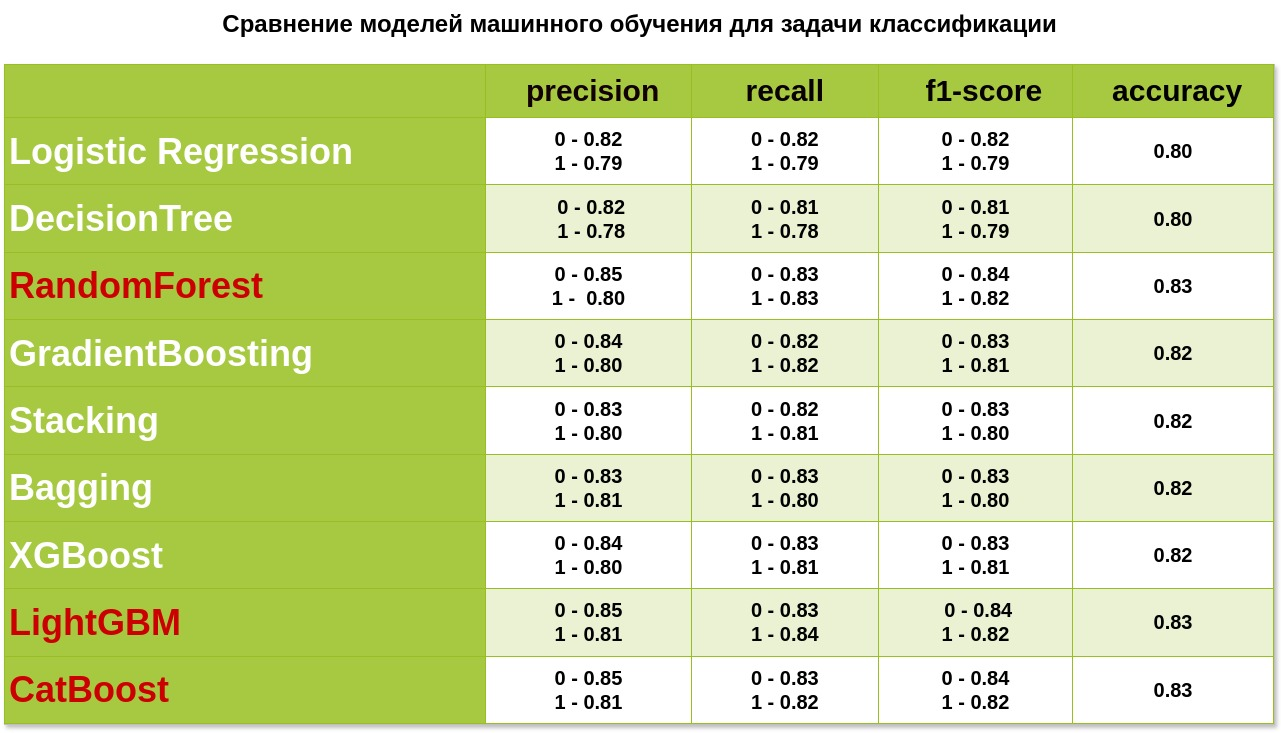